In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
import statsmodels.formula.api as smf
import shutil

In [2]:
%load_ext tensorboard

In [3]:
train_raw_dataset = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/dacon_basic_irisdataset/iris_train.csv")
test_raw_dataset = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/dacon_basic_irisdataset/iris_test.csv")
test_raw_dataset.shape

(75, 4)

In [4]:
test_raw_dataset.head()

,id,species,sepal length (cm),petal length (cm)
0,0,setosa,5.4,1.7
1,1,setosa,5.7,1.5
2,2,setosa,5.3,1.5
3,3,setosa,5.1,1.9
4,4,virginica,6.0,4.8


In [5]:
test_raw_dataset.species.value_counts()

setosa        35
virginica     20
versicolor    20
Name: species, dtype: int64

In [6]:
test_raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 75 non-null     int64  
 1   species            75 non-null     object 
 2   sepal length (cm)  75 non-null     float64
 3   petal length (cm)  75 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ KB


In [7]:
test_raw_dataset.isnull().sum()

id                   0
species              0
sepal length (cm)    0
petal length (cm)    0
dtype: int64

In [8]:
train_raw_dataset = train_raw_dataset.drop("id", axis=1)
test_raw_dataset = test_raw_dataset.drop("id", axis=1)
train_raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            75 non-null     object 
 1   sepal length (cm)  75 non-null     float64
 2   petal length (cm)  75 non-null     float64
 3   sepal width (cm)   75 non-null     float64
 4   petal width (cm)   75 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.1+ KB


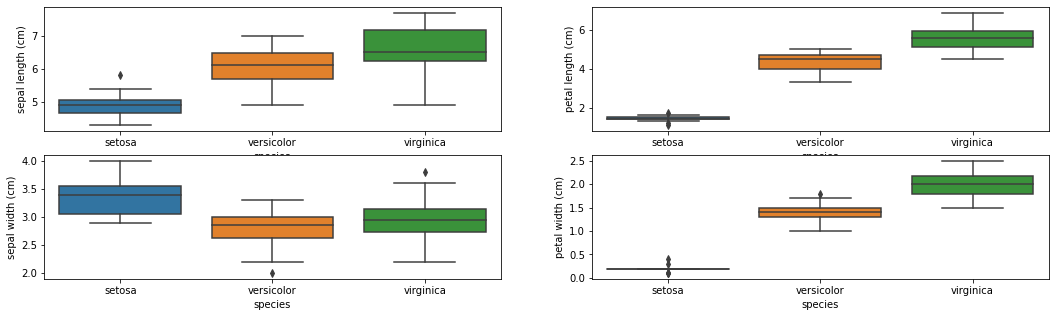

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(18, 5))
col = ['sepal length (cm)', 'petal length (cm)', 'sepal width (cm)',
       'petal width (cm)']

for idx, name in enumerate(col):
    i = idx // 2
    j = idx % 2
    sns.boxplot(x="species", y=name, data=train_raw_dataset, ax=ax[i][j])

# 실험해 본다면 sepal length 와 width의 outlier를 제거하는 것은 어떨까?

In [12]:
# 라벨 구분
LABEL = ['sepal width (cm)', 'petal width (cm)']
X_train = train_raw_dataset.copy()
X_train = X_train.drop(LABEL, axis=1)
y_train = train_raw_dataset[LABEL]
y_train.head()

# X_train, y_train = train_raw_dataset[0~1:1~2] 이런식으로 하는 방법은 없을까?


,sepal width (cm),petal width (cm)
0,2.9,0.2
1,3.2,1.5
2,2.8,1.8
3,3.6,2.5
4,3.0,0.2


In [13]:
# 범주형 데이터 species 처리
col = X_train["species"].unique()
species_col = {'setosa': 1, 'versicolor': 2, 'virginica': 3}
X_train["species"] = X_train.species.map(species_col)
test_raw_dataset["species"] = test_raw_dataset["species"].map(species_col)
X_train.head()
test_raw_dataset.head()

# map 말고 apply로 적용해보는 것은 어떨까?

,species,sepal length (cm),petal length (cm)
0,1,5.4,1.7
1,1,5.7,1.5
2,1,5.3,1.5
3,1,5.1,1.9
4,3,6.0,4.8


In [14]:
## input 데이터 만들기
# inputs = {col_name : keras.Input(name=col_name, shape=(), dtype="float32") for col_name in col_names}
input_dim = X_train.shape[1]
inputs = keras.layers.Input(shape=(input_dim, ))

# tf.dataset 형식으로 만들어보는 것은 어떨까?

In [16]:
# 모델 만들기
def build_model(inputs):
    layers = keras.layers.Dense(36, activation="relu")(inputs)
    layers = keras.layers.Dense(18, activation="relu")(layers)
    layers = keras.layers.Dense(9, activation="relu")(layers)
    layers = keras.layers.Dense(4, activation="relu")(layers)
    
    output_sw = keras.layers.Dense(1, name="prd_sepal_width")(layers)
    output_pw = keras.layers.Dense(1, name="prd_petal_width")(layers)
    outputs = [output_sw, output_pw]
    
    model = keras.models.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    return model

# sub class 형식으로 만들어보는 것은 어떨까?

In [17]:
model = build_model(inputs)

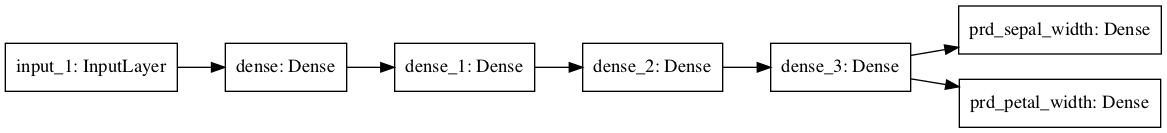

In [18]:
keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

In [19]:
y_train.head()
OUTDIR = "./iris_train"
shutil.rmtree(path=OUTDIR, ignore_errors=True)

history = model.fit(x=X_train, y={"prd_sepal_width" : y_train["sepal width (cm)"], 
                                 "prd_petal_width" : y_train["petal width (cm)"]},
                   epochs=100,
                   batch_size=16,
                   callbacks=[TensorBoard(OUTDIR)])

Epoch 1/100
5/5 [==============================] - 1s 10ms/step - loss: 8.7337 - prd_sepal_width_loss: 5.7278 - prd_petal_width_loss: 3.0059 - prd_sepal_width_mse: 5.7278 - prd_petal_width_mse: 3.0059
Epoch 2/100
5/5 [==============================] - 0s 1ms/step - loss: 7.0903 - prd_sepal_width_loss: 4.4121 - prd_petal_width_loss: 2.6782 - prd_sepal_width_mse: 4.4121 - prd_petal_width_mse: 2.6782
Epoch 3/100
5/5 [==============================] - 0s 1ms/step - loss: 5.3857 - prd_sepal_width_loss: 3.0949 - prd_petal_width_loss: 2.2908 - prd_sepal_width_mse: 3.0949 - prd_petal_width_mse: 2.2908
Epoch 4/100
5/5 [==============================] - 0s 2ms/step - loss: 3.8322 - prd_sepal_width_loss: 1.9555 - prd_petal_width_loss: 1.8767 - prd_sepal_width_mse: 1.9555 - prd_petal_width_mse: 1.8767
Epoch 5/100
5/5 [==============================] - 0s 1ms/step - loss: 2.5911 - prd_sepal_width_loss: 1.1559 - prd_petal_width_loss: 1.4353 - prd_sepal_width_mse: 1.1559 - prd_petal_width_mse: 1.4353

5/5 [==============================] - 0s 1ms/step - loss: 0.1101 - prd_sepal_width_loss: 0.0761 - prd_petal_width_loss: 0.0339 - prd_sepal_width_mse: 0.0761 - prd_petal_width_mse: 0.0339
Epoch 82/100
5/5 [==============================] - 0s 1ms/step - loss: 0.1111 - prd_sepal_width_loss: 0.0773 - prd_petal_width_loss: 0.0338 - prd_sepal_width_mse: 0.0773 - prd_petal_width_mse: 0.0338
Epoch 83/100
5/5 [==============================] - 0s 1ms/step - loss: 0.1096 - prd_sepal_width_loss: 0.0761 - prd_petal_width_loss: 0.0336 - prd_sepal_width_mse: 0.0761 - prd_petal_width_mse: 0.0336
Epoch 84/100
5/5 [==============================] - 0s 1ms/step - loss: 0.1107 - prd_sepal_width_loss: 0.0770 - prd_petal_width_loss: 0.0337 - prd_sepal_width_mse: 0.0770 - prd_petal_width_mse: 0.0337
Epoch 85/100
5/5 [==============================] - 0s 1ms/step - loss: 0.1102 - prd_sepal_width_loss: 0.0763 - prd_petal_width_loss: 0.0339 - prd_sepal_width_mse: 0.0763 - prd_petal_width_mse: 0.0339
Epoch 86

In [20]:
%tensorboard --logdir ./iris_train

In [23]:
# 테스트
pred = model.predict(test_raw_dataset)
pred

AttributeError: 'list' object has no attribute 'shape'

In [27]:
# 제출 파일 불러서 내용 입력
sample_submission = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/dacon_basic_irisdataset/sample_submission.csv")
sample_submission["sepal width (cm)"] = pred[0]
sample_submission["petal width (cm)"] = pred[1]
sample_submission.head()

,id,sepal width (cm),petal width (cm)
0,0,3.571142,0.298119
1,1,3.878306,0.181236
2,2,3.592338,0.225267
3,3,3.263979,0.415002
4,4,2.797651,1.783073


In [31]:
# 제출 파일 만들기
sample_submission.to_csv("submission_tf_1.csv", index=False)

In [32]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'submission_tf_1.csv', 
'369d8186e100432064ec63e2c634a2b89a5791d577c9b056c4f5e36c999fca14', 
'235836', 
'쵸비 우승 기원', 
'첫 submission' )

{'isSubmitted': True, 'detail': 'Success'}
